In [1]:
"""
Imports
"""
import pandas as pd
from constants import *
import pandas_utils
from sklearn.metrics import cohen_kappa_score
import krippendorff
from collections import defaultdict
import open_coding_utils as oc
import metric_utils
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import pmi_utils

min_count = 50 # used to set minimum count threshold for many plots

/home/jmire/story-perceptions/src/open_coding_utils.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  code_id_short_name_dict = {row[1]: row[2] for _, row in codes_df.iterrows()}


In [2]:
# load dataframes
pc_df = pd.read_csv(POTATO_CODED_PATH, converters=pandas_utils.get_list_converters(POTATO_CODED_PATH))
sp_df = pd.read_csv(SP_PATH, converters=pandas_utils.get_list_converters(SP_PATH))

# additions in support of experiments/analysis
pc_df['goal_codes_filtered'] = pc_df['goal_codes'].apply(lambda x: oc.remove_all_but_primary_discourse_code(x))

### Open Coding Agreement Among Two Annotators

In [3]:
# Open Coding Agreement - Jaccard Index
def get_jaccard_index(list1, list2):
    set1, set2 = set(list1), set(list2)
    
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    
    if len(union) == 0:
        return 0.0  # Handle empty sets
    
    return len(intersection) / len(union)

pr_ann1_df = pd.read_csv(POTATO_CODED_RAW_UNFILTERED_ANNOTATOR1_PATH, converters=pandas_utils.get_list_converters(POTATO_CODED_RAW_UNFILTERED_ANNOTATOR1_PATH))
pr_ann2_df = pd.read_csv(POTATO_CODED_RAW_UNFILTERED_ANNOTATOR2_PATH, converters=pandas_utils.get_list_converters(POTATO_CODED_RAW_UNFILTERED_ANNOTATOR2_PATH))

global_jaccard_indices = []
goal_jaccard_indices = []
rationale_jaccard_indices = []
alternative_jaccard_indices = []

col_jaccard_indices_tuples = [
    ('goal_codes', goal_jaccard_indices),
    ('story_decision_explanation_codes', rationale_jaccard_indices), 
    ('story_alternative_codes', alternative_jaccard_indices)
]
for i, row in pr_ann2_df.iterrows():
    user, instance_id = row['user'], row['instance_id']
    mask = (pr_ann1_df['user'] == user) & (pr_ann1_df['instance_id'] == instance_id)
    matching_row = pr_ann1_df.loc[mask].iloc[0]

    global_ann1_codes, global_ann2_codes = [], []
    for col, category_jaccard_indices in col_jaccard_indices_tuples:
        if pd.isna(matching_row[col]) and pd.isna(row[col]):
            continue
        ann1_codes = oc.get_pos_agnostic_codes(matching_row[col].split())
        ann2_codes = oc.get_pos_agnostic_codes(row[col].split())

        category_jaccard_indices.append(get_jaccard_index(ann1_codes, ann2_codes))
        
        global_ann1_codes.extend(ann1_codes)
        global_ann2_codes.extend(ann2_codes)
    global_jaccard_indices.append(get_jaccard_index(global_ann1_codes, global_ann2_codes))
    

print("Jaccard Indices")
print('global', round(metric_utils.get_avg(global_jaccard_indices), 3))
for col, category_jaccard_indices in col_jaccard_indices_tuples:
    print(col, round(metric_utils.get_avg(category_jaccard_indices), 3))

Jaccard Indices
global 0.553
goal_codes 0.515
story_decision_explanation_codes 0.613
story_alternative_codes 0.75


### Crowd Perceptions

/home/jmire/story-perceptions/src/open_coding_utils.py:173: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.barplot(x=sorted_code_proportions, y=sorted_code_names, hue=is_negative_code, palette=palette, ax=ax, legend=False)


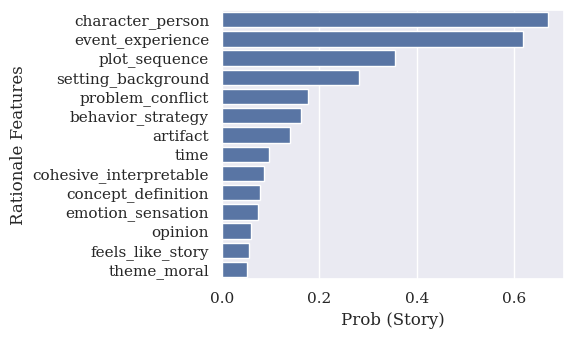

In [4]:
pc_yes_df = pc_df.loc[pc_df['label'] == 1]
code_counts_feature_y = oc.get_code_names_and_counts(pc_yes_df, ['rationale_codes'], 'feature')
oc.plot_props(code_counts_feature_y, len(pc_yes_df), out_filename='features_rationales_story', group1_name='Story', y_axis_label='Rationale Features')

dict_items([('1c', 348), ('1b', 606), ('1s', 72), ('1e', 276), ('1a', 657), ('1k', 21), ('1i', 38), ('1t', 94), ('1d', 174), ('1r', 137), ('!1j', 14), ('1q', 76), ('1h', 44), ('1p', 159), ('1m', 53), ('!1h', 28), ('1j', 84), ('1g', 50), ('1o', 58), ('1n', 4), ('!1e', 2), ('1f', 2), ('!1m', 3), ('!1c', 3), ('!1a', 2), ('!1k', 1), ('!1d', 1), ('!1t', 1), ('!1b', 1), ('1l', 1), ('!1i', 1), ('!1s', 1)])
dict_items([('1o', 293), ('1q', 202), ('1r', 284), ('!1c', 404), ('!1a', 246), ('1s', 48), ('!1h', 98), ('!1b', 176), ('!1t', 38), ('!1e', 80), ('!1i', 11), ('1a', 309), ('1b', 188), ('1p', 277), ('!1g', 31), ('1e', 137), ('1d', 96), ('!1m', 74), ('!1j', 139), ('1g', 19), ('!1f', 6), ('!1k', 21), ('1h', 59), ('!1d', 36), ('1t', 16), ('1m', 1), ('1j', 8), ('!1o', 3), ('1c', 15), ('!1s', 6), ('!1q', 1), ('1k', 1), ('1f', 2), ('!1l', 6), ('1n', 3), ('1i', 1), ('!1n', 1), ('!1p', 1)])
dict_items([('!1b', -0.11522898075320118), ('!1h', -0.03618689041592099), ('1o', -0.13440373705422848), ('1e', 

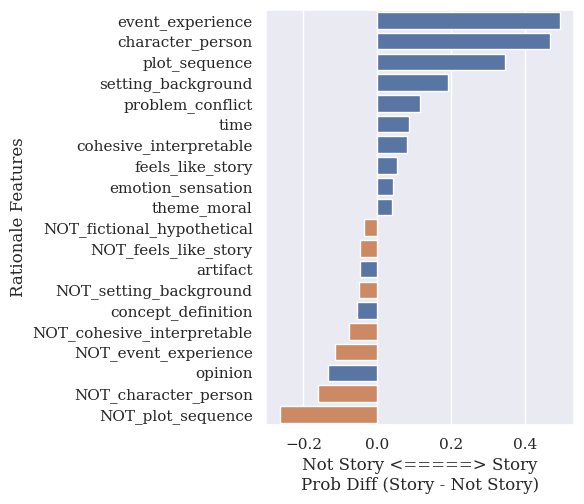

In [5]:
pc_yes_df = pc_df.loc[pc_df['label'] == 1]
pc_no_df = pc_df.loc[pc_df['label'] == 0]

code_counts_feature_y = oc.get_code_names_and_counts(pc_yes_df, ['rationale_codes'], 'feature')
print(code_counts_feature_y.items())
code_counts_feature_n = oc.get_code_names_and_counts(pc_no_df, ['rationale_codes'], 'feature')
print(code_counts_feature_n.items())
_ = oc.plot_proportion_diffs(code_counts_feature_y, len(pc_yes_df), code_counts_feature_n, len(pc_no_df), out_filename='features_rationales_story_notstory', min_code_count=min_count, group1_name='Story', group2_name='Not Story', y_axis_label='Rationale Features', arrow_caption='Not Story <=====> Story')

story count: 981
non-story count: 1514
dict_items([('2f', -0.05990773171096272), ('2d', 0.08494284402323132), ('2a', 0.1529624288159307), ('2b', -0.017092929464313372), ('2c', -0.047658483444359606), ('2e', -0.11352756535333824)])


/home/jmire/story-perceptions/src/open_coding_utils.py:146: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.barplot(x=sorted_code_proportions, y=sorted_code_names, hue=is_negative_code, palette=palette, ax=ax, legend=False)


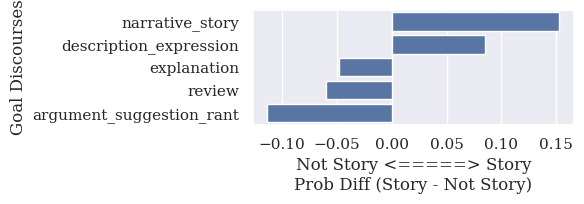

In [6]:
code_counts_feature_y = oc.get_code_names_and_counts(pc_yes_df, ['goal_codes_filtered'], 'discourse')
code_counts_feature_n = oc.get_code_names_and_counts(pc_no_df, ['goal_codes_filtered'], 'discourse')
print('story count:', len(pc_yes_df))
print('non-story count:', len(pc_no_df))
_ = oc.plot_proportion_diffs(code_counts_feature_y, len(pc_yes_df), code_counts_feature_n, len(pc_no_df), out_filename='discourse_goals_filtered_story_notstory', min_code_count=min_count, group1_name='Story', group2_name='Not Story', y_axis_label='Goal Discourses', arrow_caption='Not Story <=====> Story', threshold=0.03)

#### Story Rationale Feature Co-occurrence (NPMI)

In [7]:
pmi_df = pmi_utils.execute(pc_df, ['rationale_codes'], 'features_rationales_pmi_ignore', filter='feature', min_cooccur=20, plot_matrix=False)

template = """
\\begin{table}[t]
\\begin{center}
\small
\setlength{\\tabcolsep}{2pt}
\\begin{tabular}{lr}
\\toprule
\multicolumn{2}{c}{\\textit{Most Co-occurring Feature Pairs (Constrained)}} \\\\
\midrule
Feature Pair & NPMI  \\\\
\midrule
{{PLACEHOLDER}}
\\bottomrule
\end{tabular}
\caption{Highest co-occuring pairs of features that consist of both a textual feature and a extra-textual feature. Scores can range from -1 (features never co-occur) to 0 (features are independent) to 1 (features always co-occur). We filter out pairs that occur less than 20 times.}
\label{tab:features_rationales_story_pmi_most_constrained}
\end{center}
\end{table}
"""

placeholder = ''
for i, row in pmi_df.loc[pmi_df['textual_and_extratextual'] == True].head(10).iterrows():
  pair = row['Most and Least Co-occuring Feature Pairs']
  one, two = pair.split(', ')
  placeholder += f'{one.replace('_', '\_')} \& {two.replace('_', '\_')} & {row['PMI']} \\\\\n'
print(template.replace('{{PLACEHOLDER}}', placeholder))

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:27: SyntaxWarning: invalid escape sequence '\_'
<>:27: SyntaxWarning: invalid escape sequence '\_'
<>:27: SyntaxWarning: invalid escape sequence '\&'
<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:27: SyntaxWarning: invalid escape sequence '\_'
<>:27: SyntaxWarning: invalid escape sequence '\_'
<>:27: SyntaxWarning: invalid escape sequence '\&'
/tmp/ipykernel_1377248/249736682.py:3: SyntaxWarning: invalid escape sequence '\s'
  template = """
/tmp/ipykernel_1377248/249736682.py:27: SyntaxWarning: invalid escape sequence '\_'
  placeholder += f'{one.replace('_', '\_')} \& {two.replace('_', '\_')} & {row['PMI']} \\\\\n'
/tmp/ipykernel_1377248/249736682.py:27: SyntaxWarning: invalid escape sequence '\_'
  placeholder += f'{one.replace('_', '\_')} \& {two.replace('_', '\_')} & {row['PMI']} \\\\\n'
/tmp/ipykernel_1377248/249736682.py:27: SyntaxWarning: invalid escape sequence '\&'
  placeholder += f'{one.replace('_', '\_')} \& {two.

dict_items([(('1c', '1s'), 14), (('1b', '1s'), 60), (('1b', '1c'), 264), (('1b', '1e'), 195), (('1a', '1i'), 24), (('1i', '1k'), 2), (('1c', '1i'), 15), (('1e', '1i'), 11), (('1a', '1c'), 256), (('1a', '1b'), 577), (('1a', '1e'), 266), (('1b', '1i'), 25), (('1c', '1e'), 89), (('1e', '1k'), 5), (('1a', '1k'), 14), (('1c', '1k'), 12), (('1b', '1k'), 15), (('1a', '1t'), 70), (('1b', '1t'), 76), (('1c', '1d'), 86), (('1a', '1d'), 189), (('1e', '1r'), 60), (('!1j', '1e'), 14), (('!1j', '1r'), 15), (('1a', '1q'), 90), (('1i', '1q'), 5), (('1o', '1q'), 56), (('1o', '1r'), 84), (('1q', '1r'), 53), (('1h', '1q'), 13), (('1h', '1r'), 16), (('!1a', '1q'), 31), (('!1c', '1q'), 33), (('!1a', '!1c'), 160), (('!1c', '1s'), 7), (('1q', '1s'), 19), (('!1h', '1o'), 24), (('!1b', '1o'), 29), (('!1a', '!1t'), 12), (('!1b', '!1e'), 17), (('!1b', '!1c'), 51), (('!1b', '!1t'), 18), (('!1c', '!1t'), 14), (('!1c', '!1e'), 43), (('!1e', '!1t'), 1), (('!1a', '!1e'), 39), (('!1a', '!1b'), 64), (('!1c', '!1i'), 4)

In [8]:
template="""
\\begin{table*}[h]
\\begin{center}
\small
\setlength{\\tabcolsep}{2pt}
\\begin{tabular}{lr|lr}
\\toprule
\multicolumn{2}{c}{\\textit{Most Co-occurring Feature Pairs}} & \multicolumn{2}{c}{\\textit{Least Co-occurring Feature Pairs}} \\\\
\midrule
Feature Pair & NPMI  & Feature Pair & NPMI \\\\
\midrule
{{PLACEHOLDER}}
\\bottomrule
\end{tabular}
\\normalsize
\caption{Most (left) and least (right) co-occuring pairs of features, irrespective of the types of features in the pair. Scores can range from -1 (features never co-occur) to 0 (features are independent) to 1 (features always co-occur). We filter out pairs that occur less than 20 times.}
\label{tab:features_rationales_story_pmi_mostleast}
\end{center}
\end{table*}
"""

placeholder = ''

# Iterate front to back and back to front at the same time
for (_i, front_row), (_, back_row) in zip(pmi_df.head(10).iterrows(), pmi_df.iloc[::-1].head(10).iterrows()):
    # Extract front pair
    front_pair = front_row['Most and Least Co-occuring Feature Pairs']
    front_one, front_two = front_pair.split(', ')
    
    # Extract back pair
    back_pair = back_row['Most and Least Co-occuring Feature Pairs']
    back_one, back_two = back_pair.split(', ')

    placeholder += f'{front_one.replace("_", "\_")} \& {front_two.replace("_", "\_")} & {front_row["PMI"]} & {back_one.replace("_", "\_")} \& {back_two.replace("_", "\_")} & {back_row["PMI"]}\\\\\n'

print(template.replace('{{PLACEHOLDER}}', placeholder))


\begin{table*}[h]
\begin{center}
\small
\setlength{\tabcolsep}{2pt}
\begin{tabular}{lr|lr}
\toprule
\multicolumn{2}{c}{\textit{Most Co-occurring Feature Pairs}} & \multicolumn{2}{c}{\textit{Least Co-occurring Feature Pairs}} \\
\midrule
Feature Pair & NPMI  & Feature Pair & NPMI \\
\midrule
NOT\_character\_person \& NOT\_plot\_sequence & 0.5 & NOT\_plot\_sequence \& event\_experience & -0.31\\
character\_person \& event\_experience & 0.43 & NOT\_plot\_sequence \& character\_person & -0.28\\
cohesive\_interpretable \& plot\_sequence & 0.4 & NOT\_plot\_sequence \& setting\_background & -0.22\\
NOT\_character\_person \& NOT\_setting\_background & 0.38 & event\_experience \& opinion & -0.18\\
event\_experience \& plot\_sequence & 0.37 & concept\_definition \& event\_experience & -0.18\\
NOT\_character\_person \& NOT\_event\_experience & 0.35 & NOT\_cohesive\_interpretable \& character\_person & -0.17\\
NOT\_plot\_sequence \& NOT\_problem\_conflict & 0.32 & NOT\_plot\_sequence \& behavior\

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:34: SyntaxWarning: invalid escape sequence '\_'
<>:34: SyntaxWarning: invalid escape sequence '\_'
<>:34: SyntaxWarning: invalid escape sequence '\_'
<>:34: SyntaxWarning: invalid escape sequence '\_'
<>:34: SyntaxWarning: invalid escape sequence '\&'
<>:34: SyntaxWarning: invalid escape sequence '\&'
<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:34: SyntaxWarning: invalid escape sequence '\_'
<>:34: SyntaxWarning: invalid escape sequence '\_'
<>:34: SyntaxWarning: invalid escape sequence '\_'
<>:34: SyntaxWarning: invalid escape sequence '\_'
<>:34: SyntaxWarning: invalid escape sequence '\&'
<>:34: SyntaxWarning: invalid escape sequence '\&'
/tmp/ipykernel_1377248/3980761897.py:1: SyntaxWarning: invalid escape sequence '\s'
  template="""
/tmp/ipykernel_1377248/3980761897.py:34: SyntaxWarning: invalid escape sequence '\_'
  placeholder += f'{front_one.replace("_", "\_")} \& {front_two.replace("_", "\_")} & {front_row["PMI"]}

100%|██████████| 2495/2495 [00:00<00:00, 793327.91it/s]


dict_items([(('1c', '1s'), 14), (('1b', '1s'), 60), (('1b', '1c'), 264), (('1b', '1e'), 195), (('1a', '1c'), 256), (('1a', '1b'), 577), (('1a', '1e'), 266), (('1c', '1e'), 89), (('1a', '1t'), 70), (('1b', '1t'), 76), (('1c', '1d'), 86), (('1a', '1d'), 189), (('1e', '1r'), 60), (('!1j', '1e'), 14), (('!1j', '1r'), 15), (('1a', '1q'), 90), (('1o', '1q'), 56), (('1o', '1r'), 84), (('1q', '1r'), 53), (('1h', '1q'), 13), (('1h', '1r'), 16), (('!1a', '1q'), 31), (('!1c', '1q'), 33), (('!1a', '!1c'), 160), (('!1c', '1s'), 7), (('1q', '1s'), 19), (('!1h', '1o'), 24), (('!1b', '1o'), 29), (('!1b', '!1e'), 17), (('!1a', '!1e'), 39), (('!1c', '!1e'), 43), (('!1b', '!1c'), 51), (('!1a', '!1b'), 64), (('1a', '1p'), 206), (('1b', '1p'), 108), (('!1c', '1a'), 53), (('!1c', '1p'), 38), (('!1c', '1b'), 35), (('1o', '1p'), 67), (('1b', '1o'), 56), (('1a', '1o'), 115), (('1p', '1r'), 123), (('1a', '1r'), 177), (('1b', '1r'), 130), (('1b', '1m'), 28), (('1a', '1m'), 31), (('1c', '1m'), 21), (('!1a', '1r')

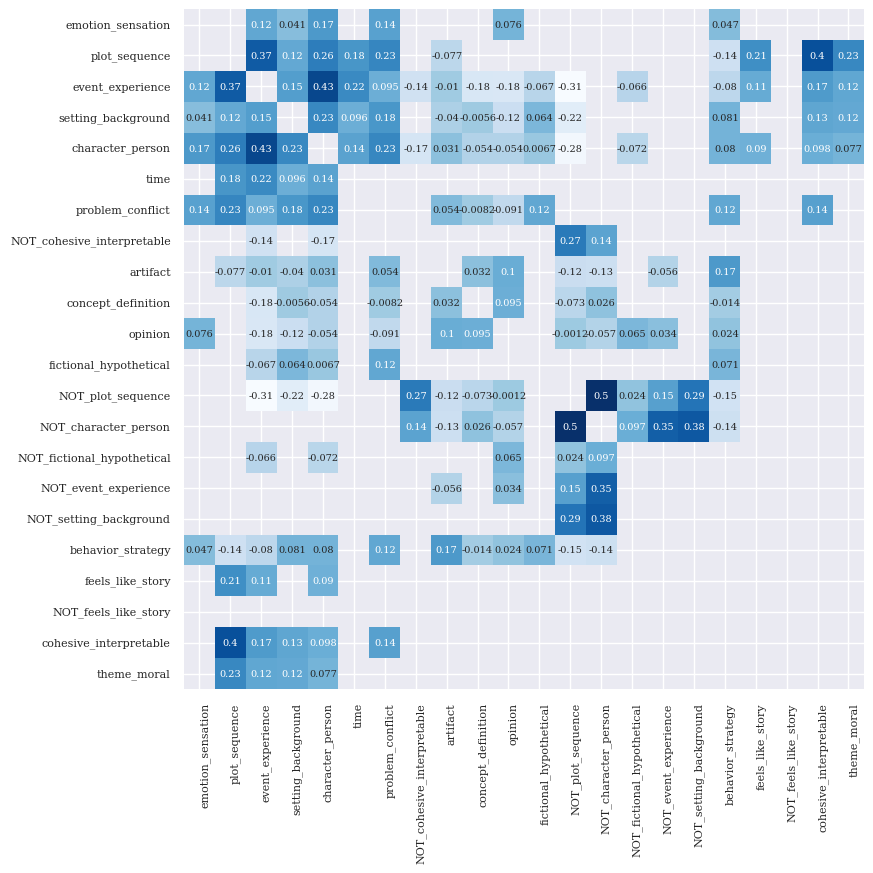

In [9]:
pmi_df = pmi_utils.execute(pc_df, ['rationale_codes'], 'features_rationales_pmi', filter='feature', min_unigram_count=40, min_cooccur=20)

### Disagreements Among Crowd Workers

majority story count: 734
minority non-story count: 152
dict_items([('!1h', -0.006570577206374715), ('1o', -0.028414308672444467), ('1e', 0.03299876599896688), ('1h', 0.005960751114427289), ('1b', 0.129825996288431), ('1r', -0.016734345405498473), ('1p', -0.02640307830645315), ('!1j', -0.03485215902351298), ('!1c', -0.09225473033729362), ('1t', 0.03709297097706097), ('1m', 0.01717557251908397), ('1g', 0.006673410625801145), ('1i', 0.01383587786259542), ('1j', 0.03387404580152672), ('1q', -0.016722388031146566), ('1a', 0.11609893053243797), ('1s', 0.00917369760278559), ('1c', 0.14014640609156478), ('1d', 0.03421243949568578)])


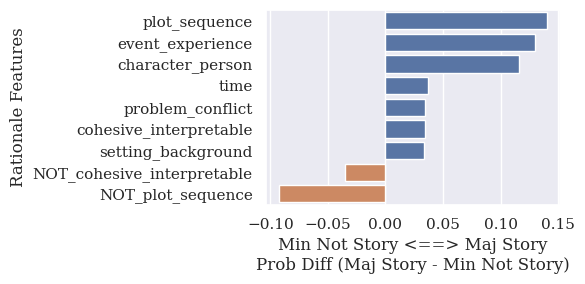

In [10]:
instance_cmv_dict = {}
for i, row in sp_df.iterrows():
  instance_cmv_dict[row['id']] = row['crowd_label_mv']

majority_df = pc_df[pc_df.apply(lambda row: row['label'] == instance_cmv_dict[row['instance_id']], axis=1)]
minority_df = pc_df[pc_df.apply(lambda row: row['label'] != instance_cmv_dict[row['instance_id']], axis=1)]

majority_y_df = majority_df.loc[majority_df['label'] == 1]
majority_n_df = majority_df.loc[majority_df['label'] == 0]

minority_y_df = minority_df.loc[minority_df['label'] == 1]
minority_n_df = minority_df.loc[minority_df['label'] == 0]

print('majority story count:', len(majority_y_df))
print('minority non-story count:', len(minority_n_df))
majority_code_counts_y = oc.get_code_names_and_counts(majority_y_df, ['rationale_codes'], 'feature')
minority_code_counts_n = oc.get_code_names_and_counts(minority_n_df, ['rationale_codes'], 'feature')
_ = oc.plot_proportion_diffs(majority_code_counts_y, len(majority_df), minority_code_counts_n, len(minority_df), min_code_count=25, out_filename='features_rationales_majorityY_minorityN', group1_name='Maj Story', group2_name='Min Not Story', y_axis_label='Rationale Features', arrow_caption='Min Not Story <==> Maj Story')

minority story count: (247, 24)
majority non-story count: (1362, 24)
dict_items([('1r', -0.0046609237427693295), ('!1c', -0.2613595153590516), ('!1e', -0.049926578560939794), ('1p', 0.068926976879678), ('1q', -0.027252135761294122), ('!1b', -0.12408223201174744), ('1a', 0.4211745052227315), ('1h', 0.043170022650662575), ('!1m', -0.0422069236119781), ('!1h', -0.04657059456503), ('1o', -0.10879154850868274), ('!1a', -0.16482072684252141), ('1s', 0.03467453792053839), ('1c', 0.18810156533319067), ('!1j', -0.0781626210561986), ('1e', 0.18239431177061594), ('1b', 0.33078587692545497), ('1d', 0.07671202744237754)])


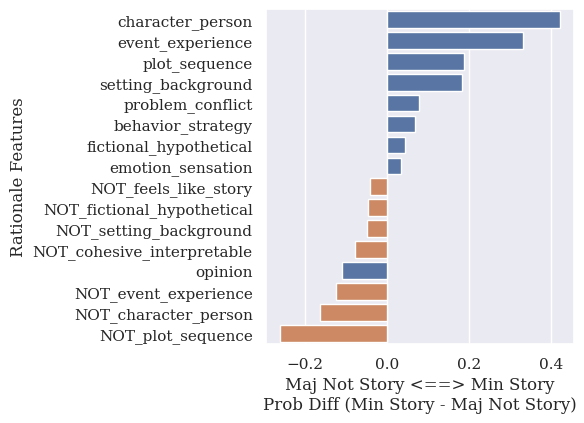

In [11]:
print('minority story count:', minority_y_df.shape)
print('majority non-story count:', majority_n_df.shape)
minority_code_counts_y = oc.get_code_names_and_counts(minority_y_df, ['rationale_codes'], 'feature')
majority_code_counts_n = oc.get_code_names_and_counts(majority_n_df, ['rationale_codes'], 'feature')
_ = oc.plot_proportion_diffs(minority_code_counts_y, len(minority_y_df), majority_code_counts_n, len(majority_n_df), out_filename='features_rationales_minorityY_majorityN', min_code_count=min_count, group1_name='Min Story', group2_name='Maj Not Story', y_axis_label='Rationale Features', arrow_caption='Maj Not Story <==> Min Story')

unanimous story count: 376
divided story count: 250
dict_items([('1r', -0.03093617021276597), ('1p', -0.1068936170212766), ('1q', -0.12008510638297873), ('1a', 0.1488510638297872), ('1t', 0.010404255319148945), ('1c', 0.2934255319148936), ('1j', 0.08902127659574469), ('1e', 0.048574468085106404), ('1b', 0.23812765957446808), ('1d', 0.06746808510638297)])


/home/jmire/story-perceptions/src/open_coding_utils.py:146: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.barplot(x=sorted_code_proportions, y=sorted_code_names, hue=is_negative_code, palette=palette, ax=ax, legend=False)


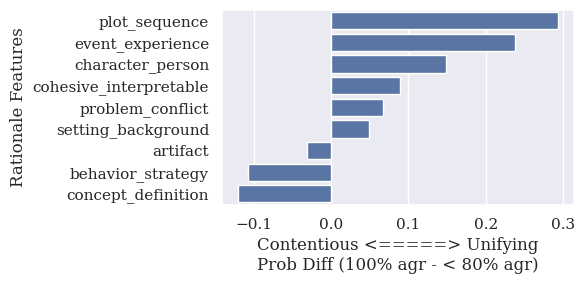

In [12]:
pc_yes_df = pc_df.loc[pc_df['crowd_label_mv'] == 1]
pc_unanimous_y_df = pc_yes_df.loc[pc_yes_df['crowd_label_mv_rate'] >= 1.0]
pc_divided_y_df = pc_yes_df.loc[pc_yes_df['crowd_label_mv_rate'] < .8]
print('unanimous story count:', len(pc_unanimous_y_df))
print('divided story count:', len(pc_divided_y_df))
code_counts_feature_y = oc.get_code_names_and_counts(pc_unanimous_y_df, ['rationale_codes'], 'feature')
code_counts_feature_n = oc.get_code_names_and_counts(pc_divided_y_df, ['rationale_codes'], 'feature')
_ = oc.plot_proportion_diffs(code_counts_feature_y, len(pc_unanimous_y_df), code_counts_feature_n, len(pc_divided_y_df), out_filename='features_rationales_storymv_highcrowdlabelmvrate_lowcrowdlabelmvrate', min_code_count=min_count, group1_name='100% agr', group2_name='< 80% agr', y_axis_label='Rationale Features', arrow_caption='Contentious <=====> Unifying')

unanimous non-story count: 701
divided non-story count: 344
dict_items([('!1c', 0.14862488803370602), ('!1b', 0.07727333045814949), ('1q', 0.04957618684271639), ('1p', -0.03965265567461765), ('1a', -0.2530728527352951), ('!1h', 0.030844640546727264), ('1o', 0.035335733006004705), ('1d', -0.04758982184918555), ('1e', -0.10430282320936868), ('!1j', 0.027452476528547258), ('1b', -0.21250787910957766), ('!1a', 0.11584364529078062), ('1r', -0.03663785953621074)])


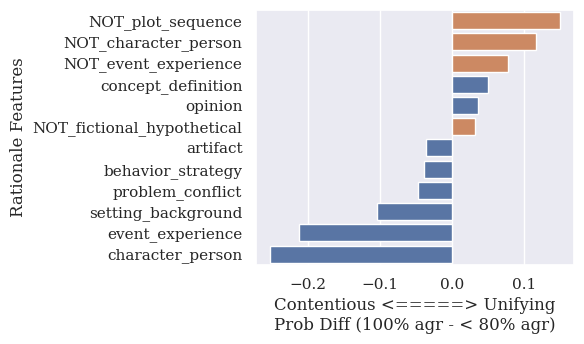

In [13]:
pc_no_df = pc_df.loc[pc_df['crowd_label_mv'] == 0]
pc_unanimous_n_df = pc_no_df.loc[pc_no_df['crowd_label_mv_rate'] >= 1.0]
pc_divided_n_df = pc_no_df.loc[pc_no_df['crowd_label_mv_rate'] < .8]
print('unanimous non-story count:', len(pc_unanimous_n_df))
print('divided non-story count:', len(pc_divided_n_df))
code_counts_feature_y = oc.get_code_names_and_counts(pc_unanimous_n_df, ['rationale_codes'], 'feature')
code_counts_feature_n = oc.get_code_names_and_counts(pc_divided_n_df, ['rationale_codes'], 'feature')
_ = oc.plot_proportion_diffs(code_counts_feature_y, len(pc_unanimous_n_df), code_counts_feature_n, len(pc_divided_n_df), out_filename='features_rationales_notstorymv_highcrowdlabelmvrate_lowcrowdlabelmvrate', min_code_count=min_count, group1_name='100% agr', group2_name='< 80% agr', y_axis_label='Rationale Features', arrow_caption='Contentious <=====> Unifying')

### Disagreements Across Annotation Contexts

### Intra-Annotator Type Story Label Agreement

In [14]:
# Krippendorff's alpha between 2+ annotators
crowd_label_reliability_dict = {}
researcher_label_reliability_dict = {}

for i, row in sp_df.iterrows():
  id = row['id']

  annotator_label_dict = {}
  for i, score in enumerate(row['crowd_labels']):
    annotator_label_dict[i] = score
  crowd_label_reliability_dict[id] = annotator_label_dict

  researcher_label_reliability_dict[id] = {0: row['maria_span'], 1: row['joel_span']}

crowd_label_reliability_df = pd.DataFrame.from_dict(crowd_label_reliability_dict)
reseracher_label_reliability_df = pd.DataFrame.from_dict(researcher_label_reliability_dict)

k_alpha_crowd = krippendorff.alpha(reliability_data=crowd_label_reliability_df)
k_alpha_researcher = krippendorff.alpha(reliability_data=reseracher_label_reliability_df)

print(f"Krippendorff's alpha")
print(f'among crowd workers: {round(k_alpha_crowd, 4)}')
print(f'among researchers: {round(k_alpha_researcher, 4)}')

Krippendorff's alpha
among crowd workers: 0.4268
among researchers: 0.6547


In [15]:
comparisons = [
  ['expert/crowd_maj', 'gold_consensus', 'crowd_label_mv'],
  ['expert/GPT-4', 'gold_consensus', 'gpt4_descriptive_label_mv'],
  ['GPT-4/crowd_maj', 'gpt4_descriptive_label_mv', 'crowd_label_mv'],
  ['expert/GPT-4t', 'gold_consensus', 'gpt4t_descriptive_label_mv'],
  ['crowd_maj/GPT-4t', 'crowd_label_mv', 'gpt4t_descriptive_label_mv'],
  ['expert/GPT-4o', 'gold_consensus', 'gpt4o_descriptive_label_mv'],
  ['crowd_maj/GPT-4o', 'crowd_label_mv', 'gpt4o_descriptive_label_mv'],
  ['Llama3/expert', 'llama3_descriptive_label_mv', 'gold_consensus',],
  ['Llama3/crowd_maj', 'llama3_descriptive_label_mv', 'crowd_label_mv'],
]

comparisons_dict = defaultdict(list)

total_instances = len(sp_df)

def to_percentage(count, total):
  percentage = (count / total) * 100
  return int(percentage)

def _round(x, digits=3):
  return round(x, digits)

indices = []
for comparison_name, col1, col2 in comparisons:
  indices.append(comparison_name)
  crosstab = pd.crosstab(sp_df[col1], sp_df[col2])
  comparisons_dict['1/0'].append(f'{to_percentage(crosstab.iat[1,0], total_instances)}%')
  comparisons_dict['0/1'].append(f'{to_percentage(crosstab.iat[0,1], total_instances)}%')
  comparisons_dict["Cohen's K"].append(_round(cohen_kappa_score(sp_df[col1], sp_df[col2])))
  report = classification_report(sp_df[col1], sp_df[col2], output_dict=True)

comparisons_df = pd.DataFrame.from_dict(comparisons_dict)
comparisons_df.index = indices
comparisons_df.to_latex(f'{OUT_DIR}/crosstab.tex', index=True, label='tab:crosstab', escape=True, float_format="%.3f")

print(comparisons_df.to_string())

                  1/0 0/1  Cohen's K
expert/crowd_maj  16%  4%      0.574
expert/GPT-4      10%  9%      0.592
GPT-4/crowd_maj   14%  4%      0.604
expert/GPT-4t     28%  1%      0.379
crowd_maj/GPT-4t  17%  2%      0.523
expert/GPT-4o     30%  0%      0.355
crowd_maj/GPT-4o  19%  0%      0.496
Llama3/expert     30%  5%      0.302
Llama3/crowd_maj  38%  1%      0.290


gc_label label
in cases of disagreement: Story / Not Story (agr: (751, 24), dis: (419, 24))
dict_items([('1r', -0.09935201751681927), ('!1c', -0.22406719441699055), ('1p', -0.055337513387082926), ('1q', -0.04220307688396378), ('1a', 0.43354763259170753), ('1t', 0.09032030482824809), ('1o', -0.09259888962687776), ('1s', 0.03876772100206884), ('1c', 0.3857005297630208), ('1j', 0.09986684420772303), ('1e', 0.16006978761810026), ('1b', 0.4457064407361386), ('1d', 0.09889121584903503)])


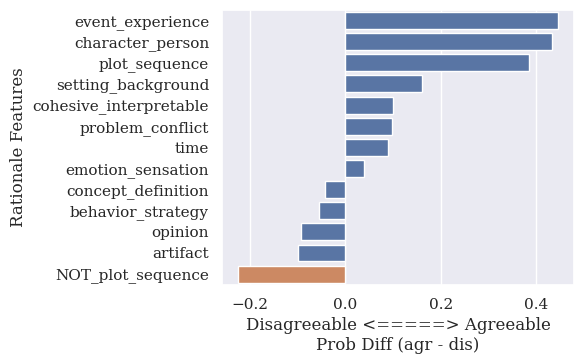

gc_label gpt4_descriptive_label_mv
in cases of disagreement: Story / Not Story (agr: (905, 24), dis: (265, 24))
dict_items([('1r', -0.17443969561138328), ('!1c', -0.08308141353069946), ('1p', -0.1770249139997915), ('1q', -0.043323256541227984), ('1a', 0.2123214844157198), ('1t', 0.03362868758469718), ('1o', -0.07221932659230688), ('1s', 0.024788908579172313), ('1c', 0.27157302199520483), ('1j', 0.05360158448868968), ('1e', 0.09942666527676433), ('1b', 0.32636297300114664), ('1d', 0.048577087459605955)])


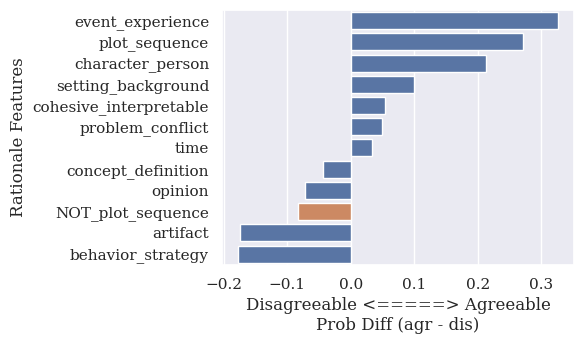

gc_label gpt4t_descriptive_label_mv
in cases of disagreement: Story / Not Story (agr: (461, 24), dis: (709, 24))
dict_items([('1r', -0.10354322638282508), ('!1c', -0.08669752699258679), ('1p', -0.1147104626295323), ('1q', -0.06629972862086163), ('1a', 0.21937959118736794), ('1t', 0.04965901685487794), ('1o', -0.08452832959562367), ('1s', 0.03946470694418523), ('1c', 0.28660941290932507), ('1j', 0.06603966969456843), ('1e', 0.05090729970108521), ('1b', 0.2920614718111421), ('1d', 0.054514469984610625)])


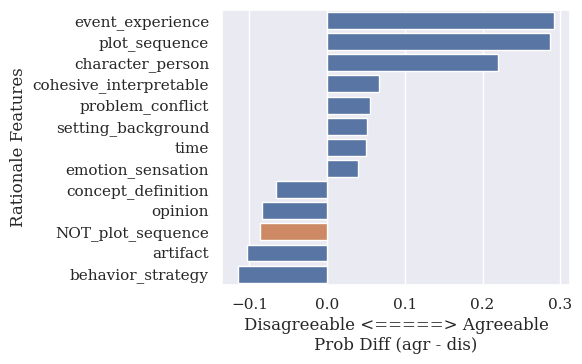

gc_label gpt4o_descriptive_label_mv
in cases of disagreement: Story / Not Story (agr: (406, 24), dis: (764, 24))
dict_items([('1r', -0.05625048358393728), ('!1c', -0.08924380367781704), ('1p', -0.12059938617078894), ('1q', -0.06322054006654115), ('1a', 0.1895133211255255), ('1t', 0.05501895649034121), ('1o', -0.07546488535836794), ('1s', 0.05040234183581358), ('1c', 0.2818907487168906), ('1j', 0.09797410569210534), ('1e', 0.04888711216568231), ('1b', 0.2896667784282877), ('1d', 0.09548526036159183)])


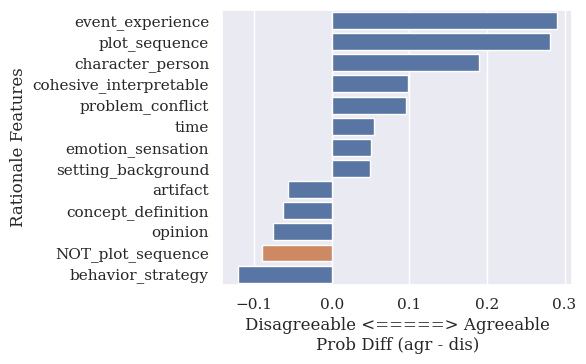

gpt4_descriptive_label_mv label
in cases of disagreement: Story / Not Story (agr: (746, 24), dis: (401, 24))
dict_items([('1r', -0.035497716833920556), ('!1c', -0.25551737278786946), ('1p', -0.024399457121271895), ('1q', -0.016018933898497727), ('1a', 0.4135405454192936), ('1t', 0.09439537884511241), ('1o', -0.10482841154486439), ('1s', 0.027685477994022982), ('1c', 0.3877437772860075), ('!1j', -0.10495543981868385), ('1j', 0.09651474530831099), ('1e', 0.1577490589879189), ('1b', 0.45250479698876134), ('1d', 0.12454453678137097)])


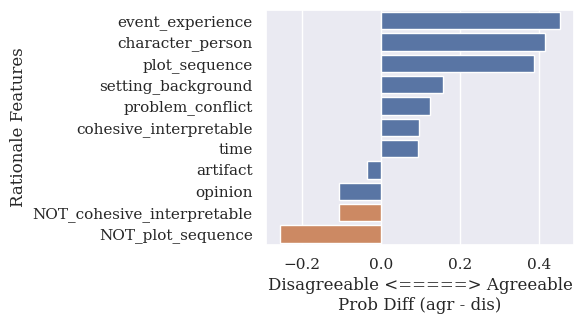

label gpt4t_descriptive_label_mv
in cases of disagreement: Story / Not Story (agr: (426, 24), dis: (555, 24))
dict_items([('1r', -0.06428118259104175), ('1p', -0.09977160258850401), ('1q', -0.07054942266209872), ('1a', 0.07757898743814229), ('1t', 0.02979317345514529), ('1m', -0.029107981220657275), ('1g', -0.027851795457429253), ('1o', -0.04226620987184367), ('1s', 0.03623905595736581), ('1c', 0.21941377997716022), ('1j', 0.05196041111534069), ('1e', 0.0006090597639893391), ('1b', 0.16532165968785695), ('1d', 0.039170156071564516)])


/home/jmire/story-perceptions/src/open_coding_utils.py:146: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.barplot(x=sorted_code_proportions, y=sorted_code_names, hue=is_negative_code, palette=palette, ax=ax, legend=False)


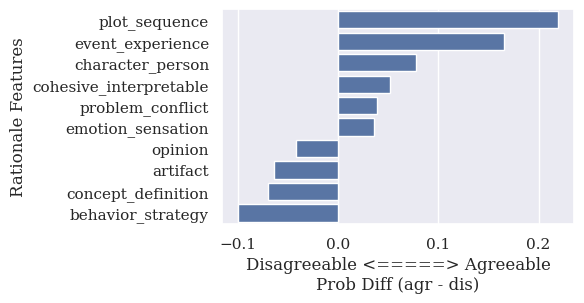

label gpt4o_descriptive_label_mv
in cases of disagreement: Story / Not Story (agr: (375, 24), dis: (606, 24))
dict_items([('1r', -0.01454785478547857), ('1p', -0.1156039603960396), ('1q', -0.06929372937293729), ('1a', 0.0295841584158415), ('1t', 0.030508250825082503), ('1m', -0.018389438943894394), ('1g', -0.017755775577557753), ('1o', -0.035273927392739275), ('1s', 0.04954455445544554), ('1c', 0.2243564356435644), ('1j', 0.09017821782178218), ('1e', -0.023762376237623783), ('1b', 0.16122772277227726), ('1d', 0.0754851485148515)])


/home/jmire/story-perceptions/src/open_coding_utils.py:146: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.barplot(x=sorted_code_proportions, y=sorted_code_names, hue=is_negative_code, palette=palette, ax=ax, legend=False)


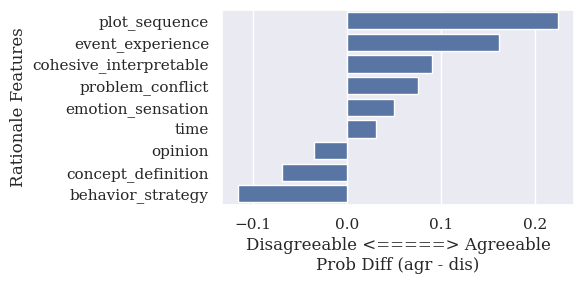

llama3_descriptive_label_mv gc_label
in cases of disagreement: Story / Not Story (agr: (1036, 24), dis: (758, 24))
dict_items([('!1b', -0.09370065504630148), ('!1h', -0.007918114118641822), ('1o', -0.10255345809435519), ('1e', 0.1126363830849319), ('1h', -0.015640121840649543), ('1b', 0.36746009107486677), ('1r', 0.025827467120343117), ('1p', -0.026298631839528935), ('!1j', -0.03694186082048879), ('!1a', -0.107280386304133), ('!1c', -0.14969285153981726), ('1t', 0.04073155326453479), ('1g', 0.008363810474628416), ('1j', 0.057270708326117296), ('1q', -0.07385061276881859), ('1a', 0.22970935503917034), ('1s', 0.015247909047381346), ('1c', 0.24436639806032945), ('1d', 0.0649239514674871)])


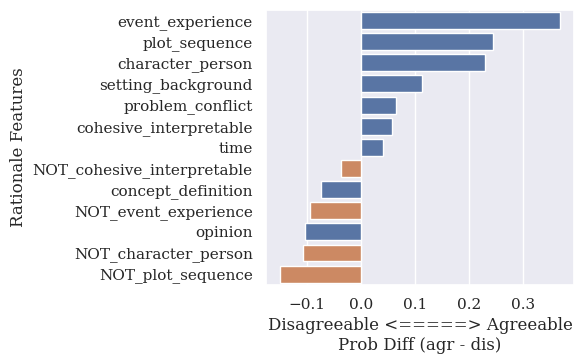

llama3_descriptive_label_mv label
in cases of disagreement: Story / Not Story (agr: (882, 24), dis: (912, 24))
dict_items([('!1b', -0.10412937104666427), ('!1h', -0.024212316505549586), ('1o', -0.13421201814058958), ('1e', 0.17716165413533833), ('1h', 0.0024018379281537175), ('1b', 0.4856113498030792), ('1r', -0.06168695548394797), ('1p', -0.02010979830528703), ('!1j', -0.08401957274137725), ('!1a', -0.1435657596371882), ('!1c', -0.27185523332139877), ('1t', 0.0899421171977563), ('1g', 0.0344984485022079), ('1j', 0.08741347416159446), ('1q', -0.048088972431077695), ('1a', 0.4410132474042248), ('1s', 0.03868301706647572), ('1c', 0.3586496001909536), ('1d', 0.11550453514739228)])


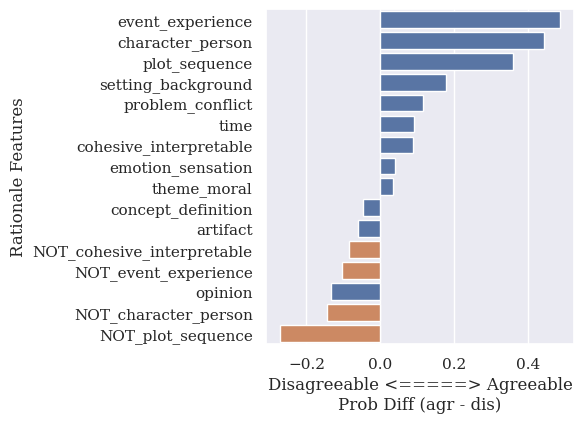

gc_label label
in cases of disagreement: Not Story / Story (agr: (1095, 24), dis: (230, 24))
dict_items([('!1c', 0.2778439547349613), ('!1e', 0.052491562437959105), ('!1b', 0.14246575342465753), ('1q', -0.008576533650982737), ('1p', -0.041135596585268996), ('1a', -0.44322017073654957), ('!1m', 0.04131427436966448), ('1h', -0.046079015286877106), ('!1h', 0.05636291443319436), ('1o', 0.12582886638872345), ('1d', -0.10516180266031366), ('1e', -0.18072265237244395), ('1c', -0.18491165376216), ('!1j', 0.08102044867976971), ('1b', -0.35419892793329366), ('!1a', 0.18195354377605719), ('1r', 0.047905499305141944)])


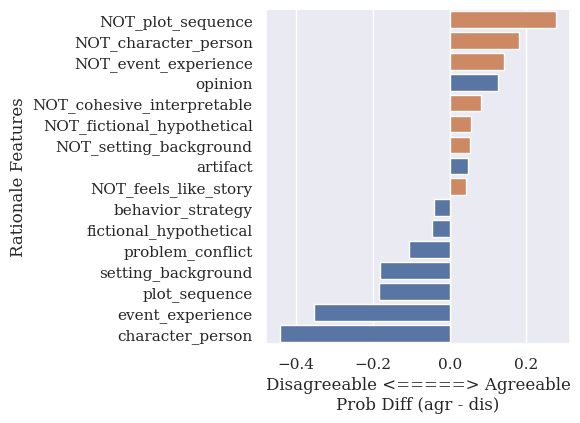

gc_label gpt4_descriptive_label_mv
in cases of disagreement: Not Story / Story (agr: (1083, 24), dis: (242, 24))
dict_items([('!1c', 0.05368466839129141), ('!1e', -0.0020107903512587497), ('!1b', 0.05809924986454827), ('1q', 0.09182482086032828), ('1p', -0.023347298215089685), ('1a', -0.2127164365895164), ('1h', -0.006188808253779293), ('!1m', -0.00346451164884809), ('!1h', 0.037556374625123054), ('1o', 0.026331051639538167), ('1d', -0.061178391825583975), ('1c', -0.04390925116183238), ('!1j', -0.01840235647840785), ('1b', -0.14442587547598879), ('1e', -0.09638439290919773), ('!1a', 0.09323275566035576), ('1r', 0.09600283876284883)])


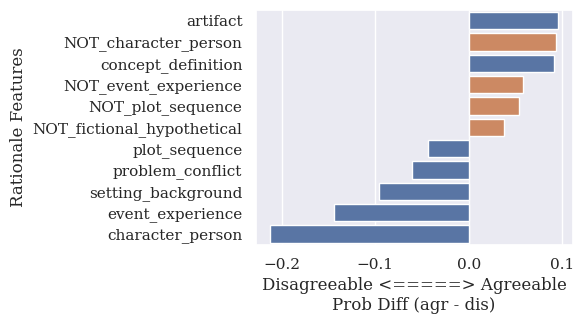

gc_label gpt4t_descriptive_label_mv
in cases of disagreement: Not Story / Story (agr: (1285, 24), dis: (40, 24))
dict_items([('!1c', 0.11235408560311283), ('!1e', -0.04941634241245137), ('!1b', 0.09562256809338521), ('1q', 0.025194552529182873), ('1p', 0.008657587548638157), ('1a', -0.3463035019455253), ('1h', -0.03142023346303502), ('!1m', -0.011867704280155641), ('!1h', 0.06147859922178988), ('1o', -0.009338521400778232), ('1d', -0.052626459143968865), ('1c', -0.0892023346303502), ('!1j', 0.005155642023346313), ('1b', -0.2614785992217899), ('1e', -0.12149805447470818), ('!1a', 0.13375486381322957), ('1r', 0.03297665369649805)])


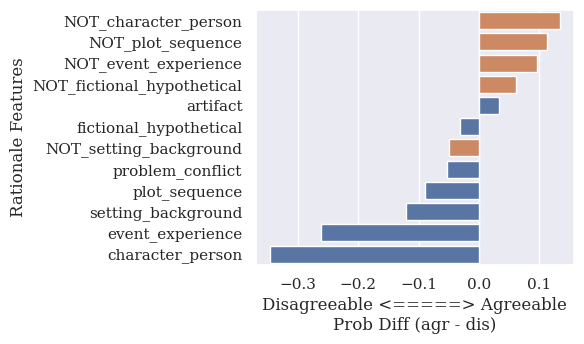

gc_label gpt4o_descriptive_label_mv
in cases of disagreement: Not Story / Story (agr: (1315, 24), dis: (10, 24))
dict_items([('!1c', 0.13498098859315588), ('!1e', 0.05247148288973384), ('!1b', 0.11863117870722434), ('1q', -0.05095057034220535), ('1p', -0.11749049429657793), ('1a', -0.6406844106463878), ('1h', 0.044866920152091254), ('!1m', -0.06197718631178708), ('!1h', 0.06007604562737642), ('1o', 0.09163498098859316), ('1d', -0.22775665399239542), ('1c', -0.16273764258555135), ('!1j', 0.0806083650190114), ('1b', -0.053992395437262364), ('1e', -0.2950570342205323), ('!1a', 0.155893536121673), ('1r', 0.15817490494296577)])


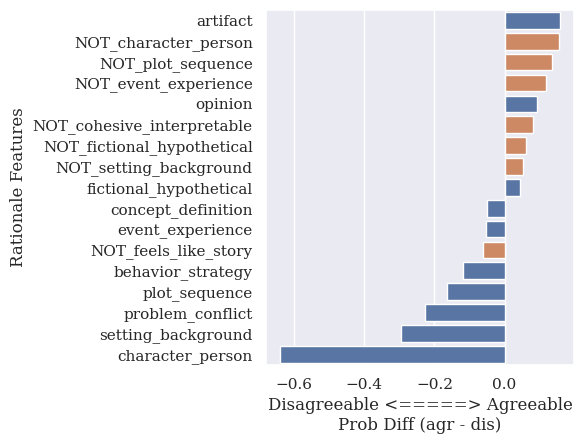

gpt4_descriptive_label_mv label
in cases of disagreement: Not Story / Story (agr: (1113, 24), dis: (235, 24))
dict_items([('!1c', 0.2619296132744547), ('!1e', 0.048754564049626276), ('!1b', 0.13387241689128482), ('1q', 0.01075490814551433), ('1p', -0.06304601326680812), ('1a', -0.42635774502494694), ('1h', -0.03550304907189692), ('!1h', 0.04790579419242606), ('1o', 0.1257976333849477), ('1d', -0.06230811875131425), ('1e', -0.1646231194203896), ('!1j', 0.06899504884249966), ('1b', -0.3417369195771444), ('!1a', 0.17813461795798205), ('1r', -0.012406568408174196)])


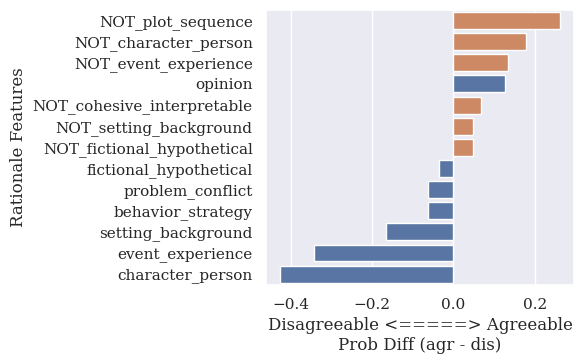

label gpt4t_descriptive_label_mv
in cases of disagreement: Not Story / Story (agr: (1439, 24), dis: (75, 24))
dict_items([('!1c', 0.014213574241371318), ('!1e', -0.07066018068102849), ('!1b', 0.0942506370164466), ('1q', 0.11231873986564744), ('1p', 0.10832522585128561), ('1a', -0.12194579569145239), ('!1m', -0.07482974287699791), ('1h', -0.0010840861709520491), ('!1h', 0.0260180681028492), ('1o', 0.09138753764188094), ('1d', 0.024628214037526054), ('1e', -0.04507760018531387), ('!1j', -0.029659485753995823), ('1b', -0.3042297892054667), ('!1a', 0.07275422747278203), ('1r', -0.027092888580032448)])


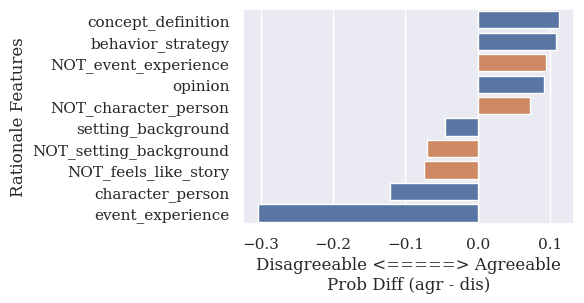

label gpt4o_descriptive_label_mv
in cases of disagreement: Not Story / Story (agr: (1473, 24), dis: (41, 24))
dict_items([('!1c', -0.001490238934975907), ('!1e', -0.045965592038812446), ('!1b', 0.11948404616429056), ('1q', 0.13713509843856075), ('1p', 0.08777507327008097), ('1a', -0.16626099051214543), ('!1m', -0.07510804232278576), ('1h', 0.014985180401702186), ('!1h', -0.008676502243637502), ('1o', 0.17384465087013395), ('1d', -0.035103406023876946), ('1e', -0.18275296805921218), ('!1j', -0.005911281108737773), ('1b', -0.3236136638352127), ('!1a', 0.06672958786614341), ('1r', -0.05788750351861971)])


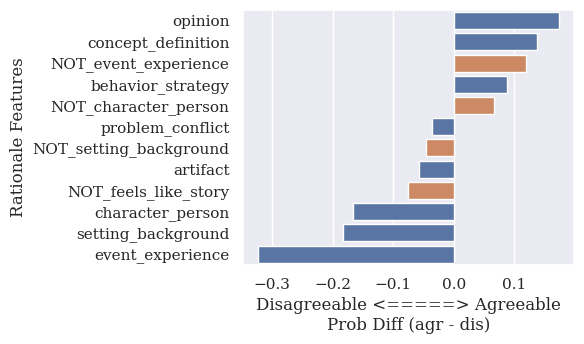

llama3_descriptive_label_mv gc_label
in cases of disagreement: Not Story / Story (agr: (567, 24), dis: (134, 24))
dict_items([('!1c', 0.11652057174445232), ('!1b', 0.0857353444418121), ('1q', 0.06700623864802968), ('1p', -0.05931980310089763), ('1a', -0.17913080102134832), ('1o', 0.07771986627708019), ('1d', -0.08576166785122008), ('!1j', 0.03987996525309958), ('1b', -0.20625707441627839), ('1e', -0.06595330227171023), ('!1a', 0.08857827265787464), ('1r', -0.12037695122272235)])


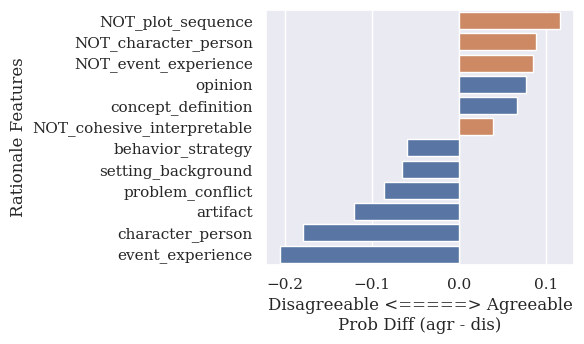

llama3_descriptive_label_mv label
in cases of disagreement: Not Story / Story (agr: (602, 24), dis: (99, 24))
dict_items([('!1c', 0.245712943387362), ('!1b', 0.132890365448505), ('1q', 0.02317191852075573), ('1p', -0.027870062753783675), ('1a', -0.47523406825732406), ('1o', 0.09154669619785899), ('1d', -0.10693311856102554), ('1e', -0.17930131883620257), ('!1j', 0.05441457767039162), ('1b', -0.42046712976945533), ('!1a', 0.1877076411960133), ('1r', -0.08335850196315311)])


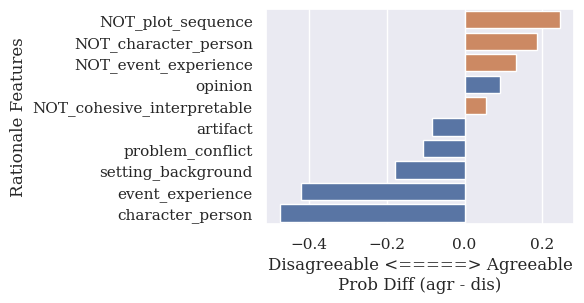

In [16]:
my_dict = defaultdict(list)

pretty_print_dict = {
  'label': 'crowd_maj',
  'gc_label': 'expert',
  'gpt4_descriptive_label_mv': 'GPT-4',
  'gpt4t_descriptive_label_mv': 'GPT-4t',
  'gpt4o_descriptive_label_mv': 'GPT-4o',
  'llama3_descriptive_label_mv': 'Llama3',
  'gpt4_negated_descriptive_label_mv': 'GPT-4 (neg)',
  'gpt4t_negated_descriptive_label_mv': 'GPT-4t (neg)',
  'gpt4o_negated_descriptive_label_mv': 'GPT-4o (neg)',
}

pairings = [
  ('gc_label', 'label'),
  ('gc_label', 'gpt4_descriptive_label_mv'),
  ('gc_label', 'gpt4t_descriptive_label_mv'),
  ('gc_label', 'gpt4o_descriptive_label_mv'),
  ('gpt4_descriptive_label_mv', 'label'),
  ('label', 'gpt4t_descriptive_label_mv'),
  ('label', 'gpt4o_descriptive_label_mv'),
  ('llama3_descriptive_label_mv', 'gc_label'),
  ('llama3_descriptive_label_mv', 'label'),
]

for col1, col2 in pairings:
  print(col1, col2)
  pc_col1_col2_agr_df = pc_df[pc_df[col1] == pc_df[col2]]
  pc_col1_col2_dis_df = pc_df[pc_df[col1] != pc_df[col2]]

  pc_col1_col2_agr_story_df = pc_col1_col2_agr_df.loc[pc_col1_col2_agr_df[col1] == 1]
  pc_col1_col2_agr_notstory_df = pc_col1_col2_agr_df.loc[pc_col1_col2_agr_df[col1] == 0]
  pc_col1_col2_dis_col1story_df = pc_col1_col2_dis_df.loc[pc_col1_col2_dis_df[col1] == 1]
  pc_col1_col2_dis_col1notstory_df = pc_col1_col2_dis_df.loc[pc_col1_col2_dis_df[col1] == 0]

  agr_df = pc_col1_col2_agr_story_df
  dis_df = pc_col1_col2_dis_col1story_df
  print(f"in cases of disagreement: Story / Not Story (agr: {agr_df.shape}, dis: {dis_df.shape})")
  code_counts_features_agr = oc.get_code_names_and_counts(agr_df, ['rationale_codes'], 'feature')
  code_counts_features_dis = oc.get_code_names_and_counts(dis_df, ['rationale_codes'], 'feature')
  x,y = oc.plot_proportion_diffs(code_counts_features_agr, len(agr_df), code_counts_features_dis, len(dis_df), out_filename=f'dis_{col1}Y_{col2}N', min_code_count=min_count, group1_name='agr', group2_name='dis', y_axis_label='Rationale Features', arrow_caption='Disagreeable <=====> Agreeable')
  if len(dis_df) > 30:
    my_dict['Story'].append(pretty_print_dict[col1])
    my_dict['Not Story'].append(pretty_print_dict[col2])
    my_dict['Code'].append(x[-1])
    my_dict['Prob'].append(y[-1])

for col1, col2 in pairings:
  print(col1, col2)
  pc_col1_col2_agr_df = pc_df[pc_df[col1] == pc_df[col2]]
  pc_col1_col2_dis_df = pc_df[pc_df[col1] != pc_df[col2]]

  pc_col1_col2_agr_story_df = pc_col1_col2_agr_df.loc[pc_col1_col2_agr_df[col1] == 1]
  pc_col1_col2_agr_notstory_df = pc_col1_col2_agr_df.loc[pc_col1_col2_agr_df[col1] == 0]
  pc_col1_col2_dis_col1story_df = pc_col1_col2_dis_df.loc[pc_col1_col2_dis_df[col1] == 1]
  pc_col1_col2_dis_col1notstory_df = pc_col1_col2_dis_df.loc[pc_col1_col2_dis_df[col1] == 0]

  agr_df = pc_col1_col2_agr_notstory_df
  dis_df = pc_col1_col2_dis_col1notstory_df
  print(f"in cases of disagreement: Not Story / Story (agr: {agr_df.shape}, dis: {dis_df.shape})")
  code_counts_features_agr = oc.get_code_names_and_counts(agr_df, ['rationale_codes'], 'feature')
  code_counts_features_dis = oc.get_code_names_and_counts(dis_df, ['rationale_codes'], 'feature')
  x, y = oc.plot_proportion_diffs(code_counts_features_agr, len(agr_df), code_counts_features_dis, len(dis_df), out_filename=f'dis_{col1}N_{col2}Y', min_code_count=min_count, group1_name='agr', group2_name='dis', y_axis_label='Rationale Features', arrow_caption='Disagreeable <=====> Agreeable')
  if len(dis_df) > 30:
    my_dict['Story'].append(pretty_print_dict[col2])
    my_dict['Not Story'].append(pretty_print_dict[col1])
    my_dict['Code'].append(x[-1])
    my_dict['Prob'].append(y[-1])

my_df = pd.DataFrame.from_dict(my_dict)
my_df.to_latex(f'{OUT_DIR}/cross-annotator-dis.tex', index=False, label='tab:cross-annotator-dis', escape=True, float_format="%.2f", caption='The most relatively prevalent code when annotator types disagree (vs. agree). We include all pairs with at least one human annotator type for which there are at least 10 disagreements.')
